In [ ]:
# importing the necessary packages
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST

# import your VAE model 
from vae_main import VAE

In [2]:
kwargs = {'root':'datasets/FashionMNIST', 
          'train':True, 
          'transform':transforms.ToTensor(), 
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

48000 12000
(28, 28, 1)


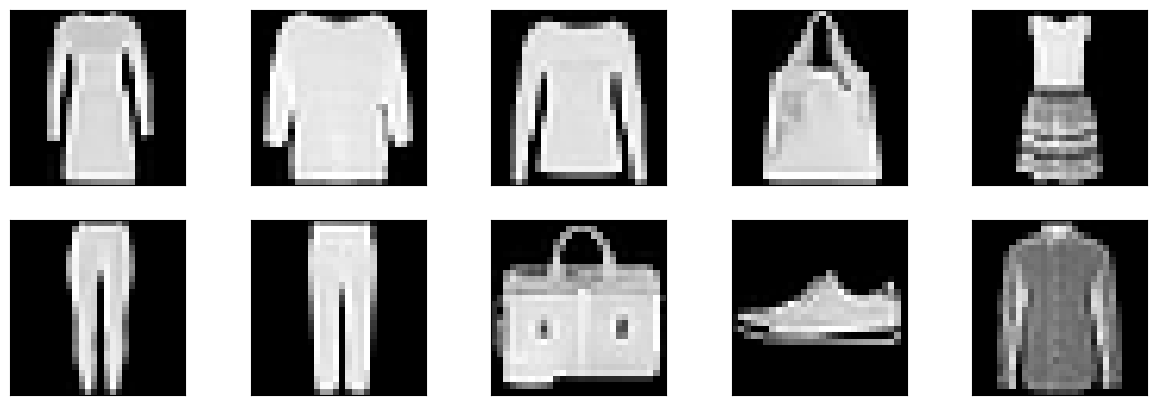

In [3]:
# showing the dataset
print(len(train_dataset), len(val_dataset))

sample_images = [train_dataset[i][0].permute(1, 2, 0).numpy() for i in range(10)]
print(sample_images[0].shape)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(15, 5)
for i in range(2):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(sample_images[i * 5 + j], cmap='gray')
plt.show()

In [4]:
def train(vae: VAE, 
          train_loader: DataLoader, 
          val_loader: DataLoader, 
          optimizer: optim, 
          epochs: int, 
          reg_factor: float=1., 
          device=torch.device('cuda'), 
          display_interval: int=5):

  itrs = tqdm(range(epochs))
  itrs.set_description(f'Train Recons Loss: ? - Train Prior Loss: ? (Total: ?)- '
                       f'Val Recons Loss: ? - Val Prior Loss: ? (Total: ?)')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    avg_prior_loss = 0.
    avg_recons_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      y = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()
      
      recons_loss, prior_loss = vae.get_loss(x, y)

      loss = recons_loss + reg_factor * prior_loss
      
      avg_prior_loss += prior_loss.item()
      avg_recons_loss += recons_loss.item()
      avg_train_loss += loss.item()

      loss.backward()
      optimizer.step()

    avg_recons_loss /= len(train_loader)
    avg_prior_loss /= len(train_loader)
    avg_train_loss /= len(train_loader)

    # validation and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      avg_val_prior_loss = 0.
      avg_val_recons_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        y = sample[1].type(torch.long).to(device)

        recons_loss, prior_loss = vae.get_loss(x, y)

        loss = recons_loss + reg_factor * prior_loss

        avg_val_prior_loss += prior_loss.item()
        avg_val_recons_loss += recons_loss.item()
        avg_val_loss += loss.item()
      
      avg_val_prior_loss /= len(val_loader)
      avg_val_recons_loss /= len(val_loader)
      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Recons Loss: {avg_recons_loss:.3f} - Train Prior Loss: {avg_prior_loss:.3f} (Total: {avg_train_loss:.3f})- '
                         f'Val Recons Loss: {avg_val_recons_loss:.3f} - Val Prior Loss: {avg_val_prior_loss:.3f} (Total: {avg_val_loss:.3f})')
    
    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(vae.state_dict(), 'vae.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = vae.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Train Recons Loss: ? - Train Prior Loss: ? (Total: ?)- Val Recons Loss: ? - Val Prior Loss: ? (Total: ?):   0%|          | 0/10 [00:00<?, ?it/s]

Train Recons Loss: 38555.839 - Train Prior Loss: 365.943 (Total: 38921.782)- Val Recons Loss: 35390.478 - Val Prior Loss: 399.643 (Total: 35790.120):   0%|          | 0/10 [00:06<?, ?it/s]

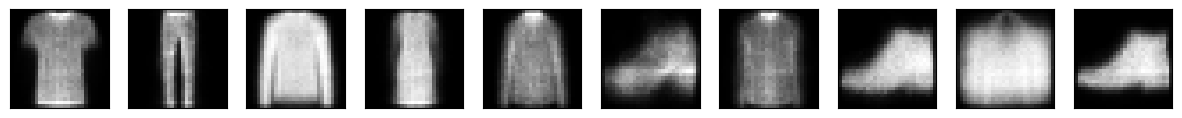

Train Recons Loss: 33073.466 - Train Prior Loss: 619.118 (Total: 33692.584)- Val Recons Loss: 32971.939 - Val Prior Loss: 618.036 (Total: 33589.974):  50%|█████     | 5/10 [00:39<00:32,  6.58s/it]

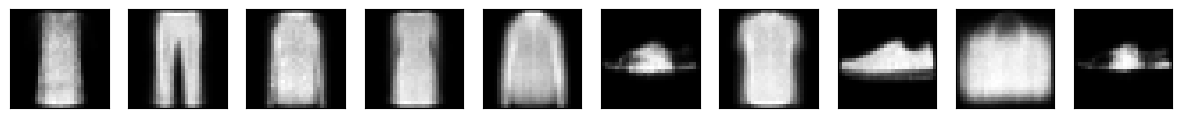

Train Recons Loss: 32560.131 - Train Prior Loss: 685.107 (Total: 33245.238)- Val Recons Loss: 32533.894 - Val Prior Loss: 671.085 (Total: 33204.980):  90%|█████████ | 9/10 [01:06<00:06,  6.57s/it]

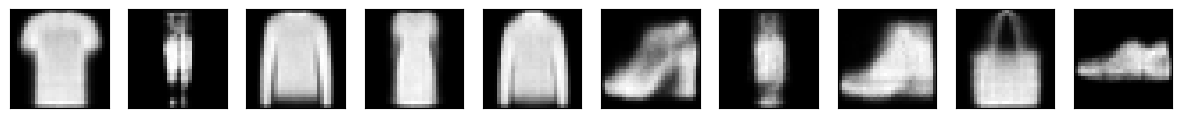

Train Recons Loss: 32560.131 - Train Prior Loss: 685.107 (Total: 33245.238)- Val Recons Loss: 32533.894 - Val Prior Loss: 671.085 (Total: 33204.980): 100%|██████████| 10/10 [01:06<00:00,  6.63s/it]


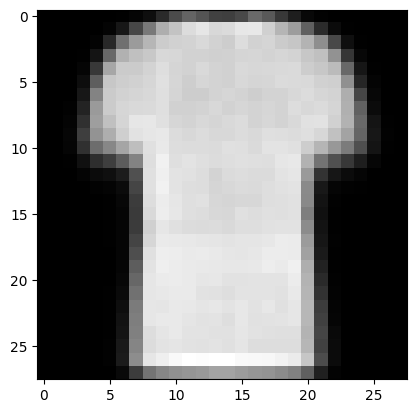

In [8]:
# setting the training hyperparameters
device = torch.device('cuda')
batch_size = None # specify your batch size
vae = None # load your model here
lr = None # specify yout
optimizer = None # specify your optimizer; e.g. optim.Adam(vae.parameters(), lr)
reg_factor = 1 # specify the regularization factor for the prior matching loss
epochs = 10 # feel free to change the epochs as needed
num_classes = 10
display_interval = 5 # feel free to change; set to None if you do not want to see generated images during the training

# defining the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# moving the model to gpu
vae = vae.to(device)

# training the model
train(vae=vae, 
      train_loader=train_loader, 
      val_loader=val_loader, 
      optimizer=optimizer, 
      epochs=epochs, 
      reg_factor=reg_factor, 
      device=device,
      display_interval=display_interval)

generated_sample = vae.generate_sample(1, torch.tensor([0]).cuda(), device)

plt.imshow(generated_sample[0].squeeze(0).cpu().numpy(), cmap='gray')
plt.show()

In [9]:
# a classifier trained on FashionMNIST (DO NOT CHANGE THE CODE BELOW)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

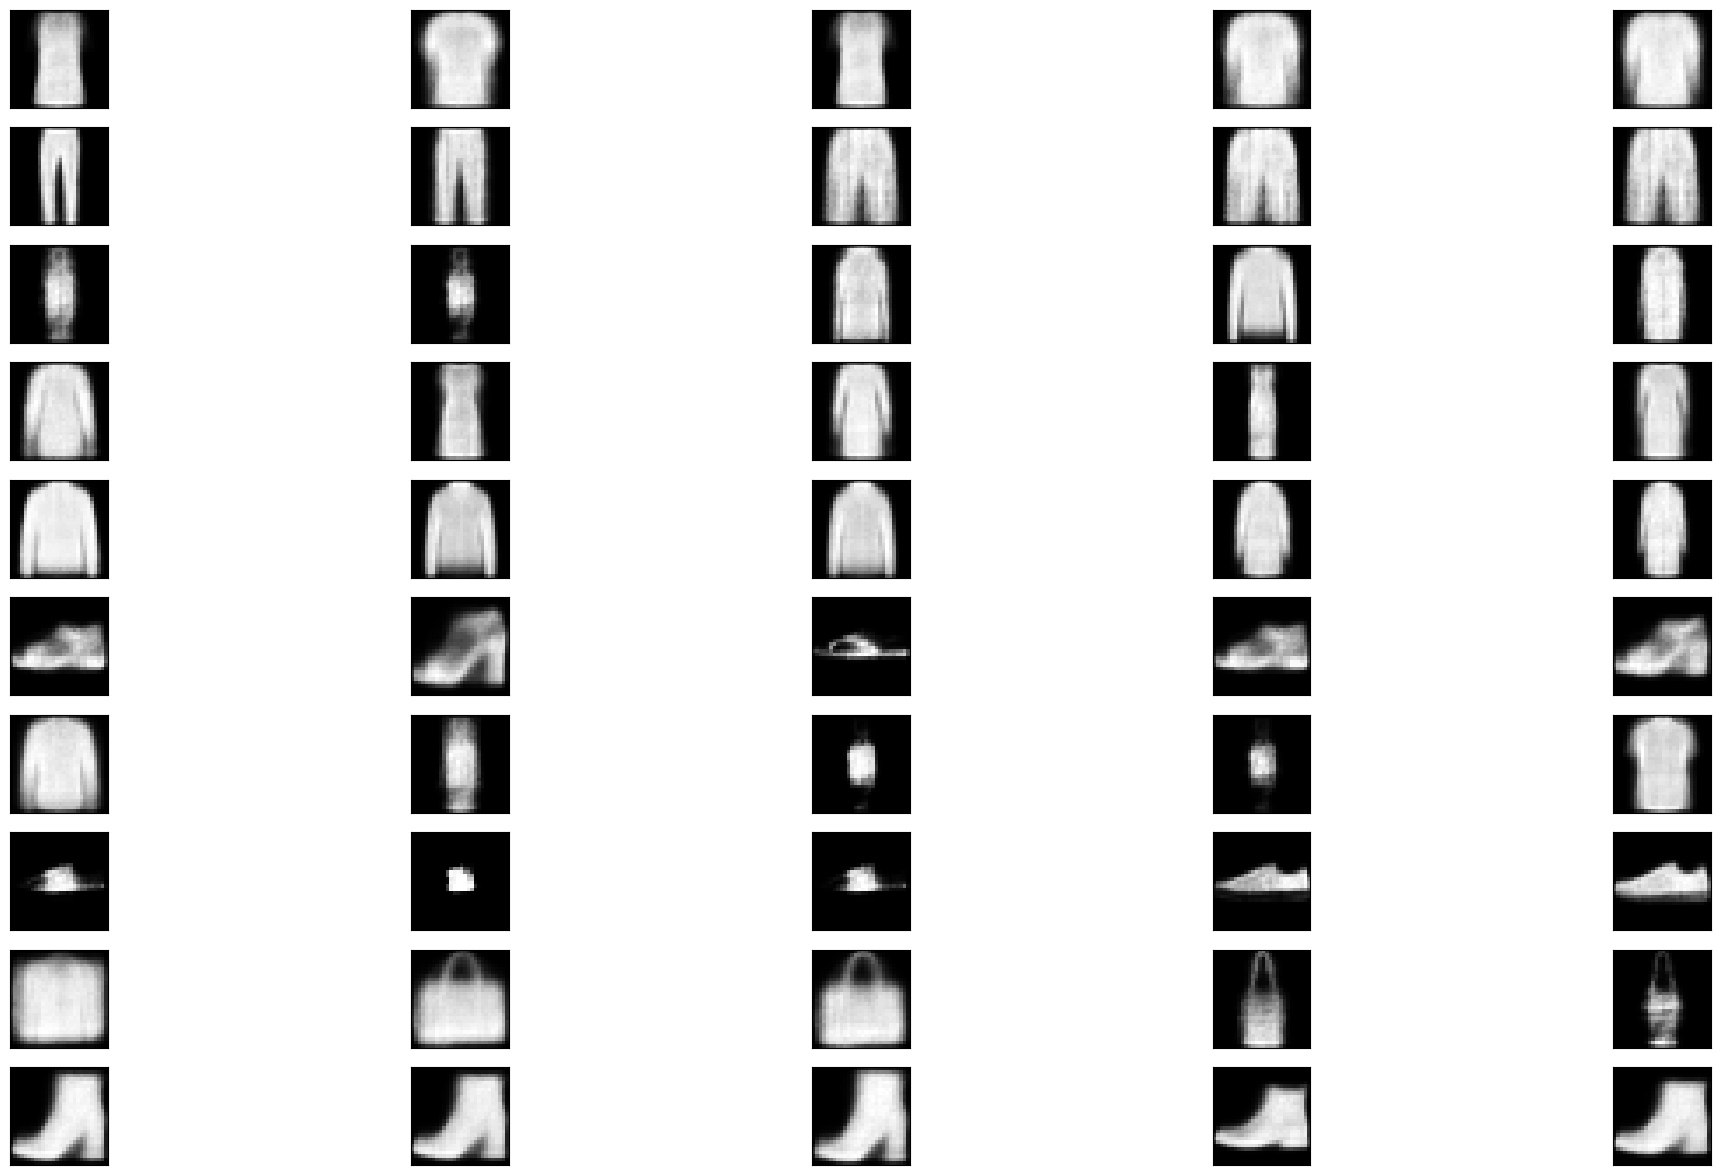

tensor([0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3,
        4, 5, 9, 5, 5, 9, 2, 3, 3, 8, 6, 7, 5, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
74.00


In [13]:
# here we use the classifier to see if how well it can classify the generated images (do not change the following code)
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).cuda()

# load your vae
vae.load_state_dict(torch.load('vae.pt'))
vae = vae.to(device)

# generate samples from the VAE
generated_samples = vae.generate_sample(50, desired_labels, torch.device('cuda'))

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')